In [1]:
import os
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import enchant
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import itertools
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

---

## Prepare The Data

In [3]:
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
initial_categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
                      'comp.sys.mac.hardware', 'comp.windows.x', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
                      'rec.sport.hockey', 'sci.electronics', 'soc.religion.christian', 'talk.politics.mideast',
                      'talk.politics.misc', 'talk.religion.misc']
eng_dict = enchant.Dict('en_US')

In [4]:
ng_train = fetch_20newsgroups(subset='train', categories=initial_categories, remove=('headers', 'footers', 'quotes'))
print ng_train.keys()

ng_test = fetch_20newsgroups(subset='test', categories=initial_categories, remove=('headers', 'footers', 'quotes'))
print ng_test.keys()

['description', 'DESCR', 'filenames', 'target_names', 'data', 'target']
['description', 'DESCR', 'filenames', 'target_names', 'data', 'target']


In [5]:
data_train = []
y_train = []

for data, lbl in log_progress(zip(ng_train.data, ng_train.target)):
    filtered = re.findall(u'(?u)\\b\\w\\w+\\b', data)
    filtered = [filt for filt in filtered if eng_dict.check(filt)]
    data_train.append(' '.join(filtered).lower())
    y_train.append(lbl)
    
y_train = np.asarray(y_train)
    
print len(data_train), len(y_train)

VBox(children=(HTML(value=u''), IntProgress(value=0, max=8401)))

8401 8401


In [6]:
data_test = []
y_test = []

for data, lbl in log_progress(zip(ng_test.data, ng_test.target)):
    filtered = re.findall(u'(?u)\\b\\w\\w+\\b', data)
    filtered = [filt for filt in filtered if eng_dict.check(filt)]
    data_test.append(' '.join(filtered).lower())
    y_test.append(lbl)
    
y_test = np.asarray(y_test)
    
print len(data_test), len(y_test)

VBox(children=(HTML(value=u''), IntProgress(value=0, max=5592)))

5592 5592


In [7]:
X_train = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)

print X_train.shape, X_test.shape

(8401, 31911) (5592, 31911)


In [8]:
X_train

<8401x31911 sparse matrix of type '<type 'numpy.float64'>'
	with 446838 stored elements in Compressed Sparse Row format>

---

## Build Models

* **Logistic Regression**
* **SVM**
* **Random Forest**
* **Gradient Boosting Trees**

**Define classifiers:**

In [9]:
predictor_lr = LogisticRegression().fit(X_train, y_train)

In [10]:
predictor_svm = LinearSVC().fit(X_train, y_train)

In [11]:
predictor_rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [12]:
predictor_gbt = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

**Evaluate Classifiers:**

In [13]:
y_pred_lr = predictor_lr.predict(X_test)
print 'LR accuracy: {}%'.format(round(np.mean(y_test == y_pred_lr), 2))

LR accuracy: 0.67%


In [14]:
y_pred_svm = predictor_svm.predict(X_test)
print 'LR accuracy: {}%'.format(round(np.mean(y_test == y_pred_svm), 2))

LR accuracy: 0.66%


In [15]:
y_pred_rf = predictor_rf.predict(X_test)
print 'RF accuracy: {}%'.format(round(np.mean(y_test == y_pred_rf), 2))

RF accuracy: 0.63%


In [16]:
y_pred_gbt = predictor_gbt.predict(X_test)
print 'GBT accuracy: {}%'.format(round(np.mean(y_test == y_pred_gbt), 2))

GBT accuracy: 0.59%


### [Confusion Matrices](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)


In [17]:
def plot_confusion_matrix(cm, title='Contingency matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    classes = [x.split('.')[-1] for x in initial_categories]
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

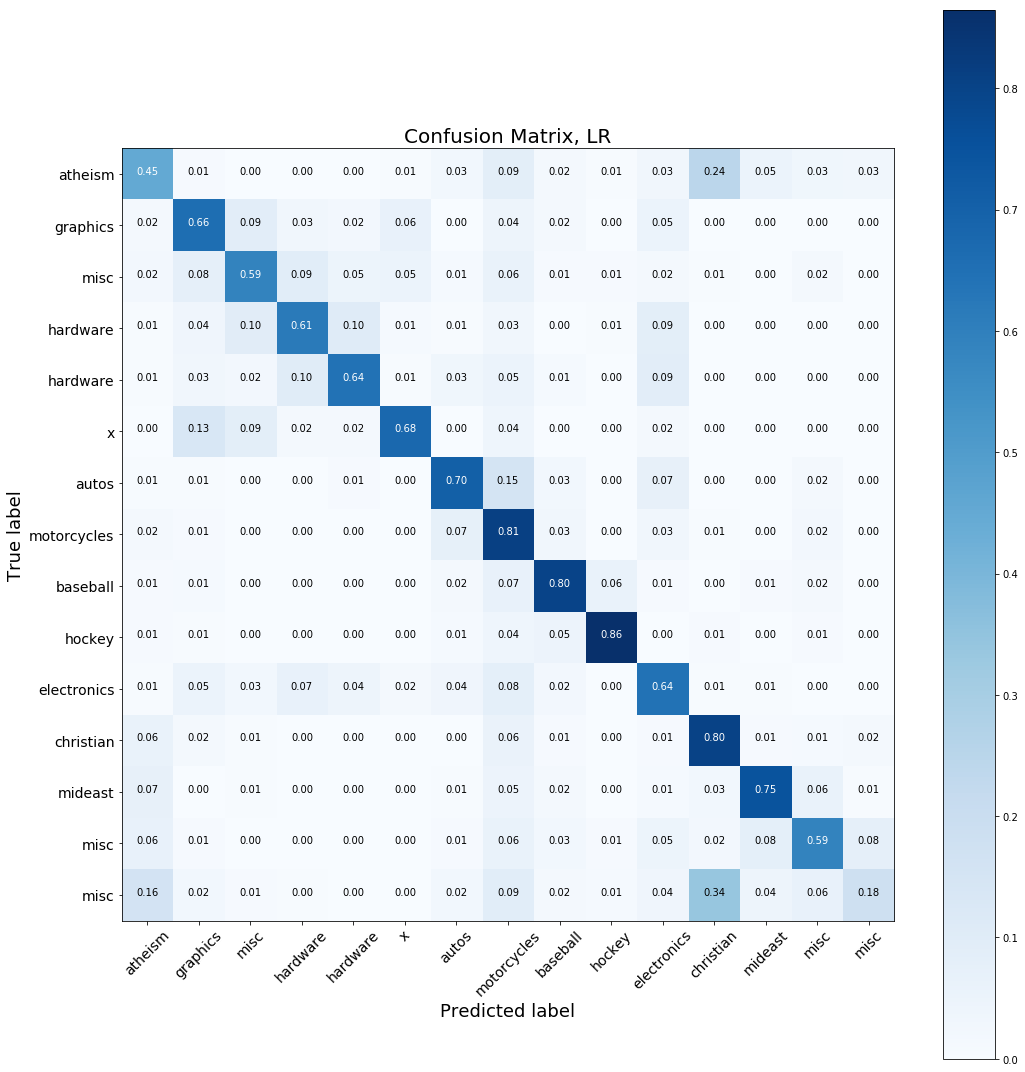

In [18]:
cmt_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cmt_lr, title='Confusion Matrix, LR')

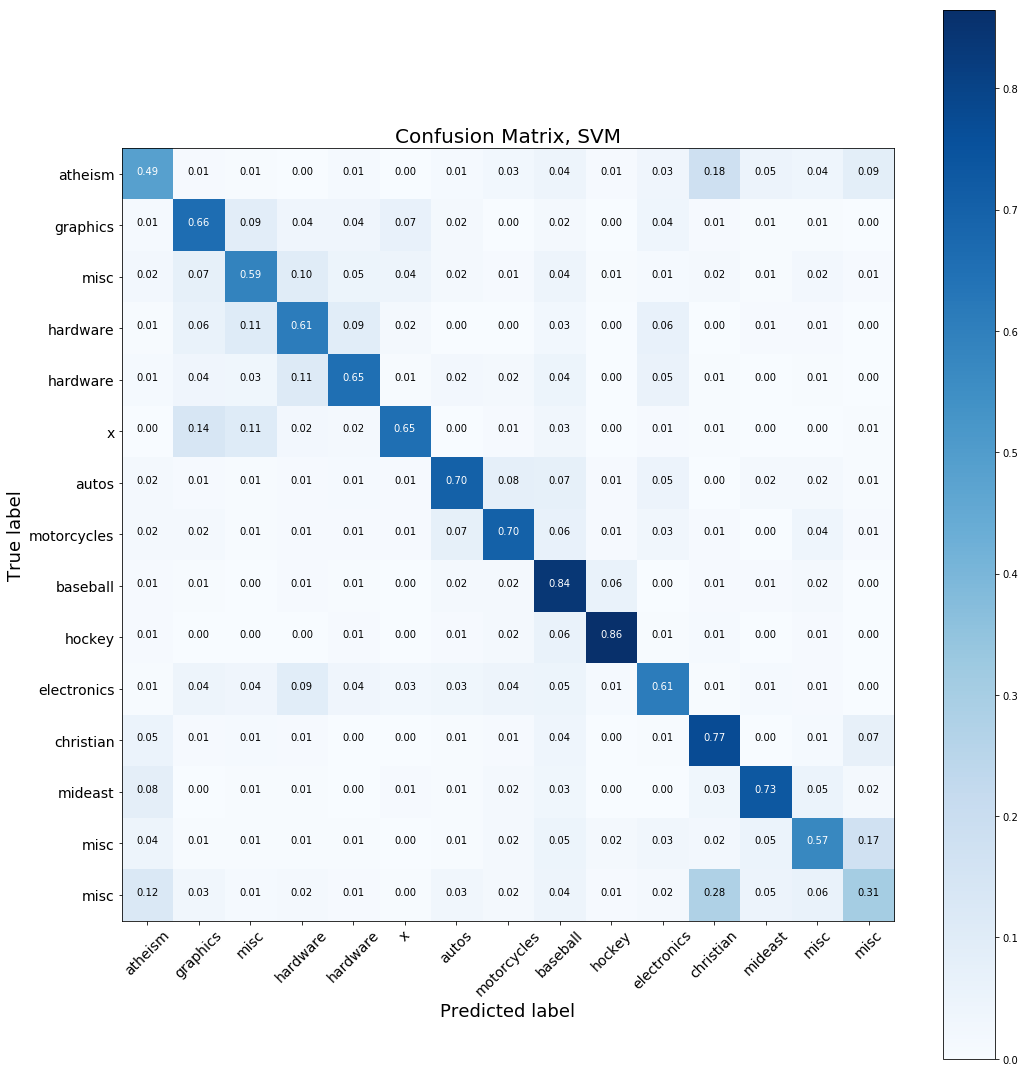

In [19]:
cmt_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cmt_svm, title='Confusion Matrix, SVM')

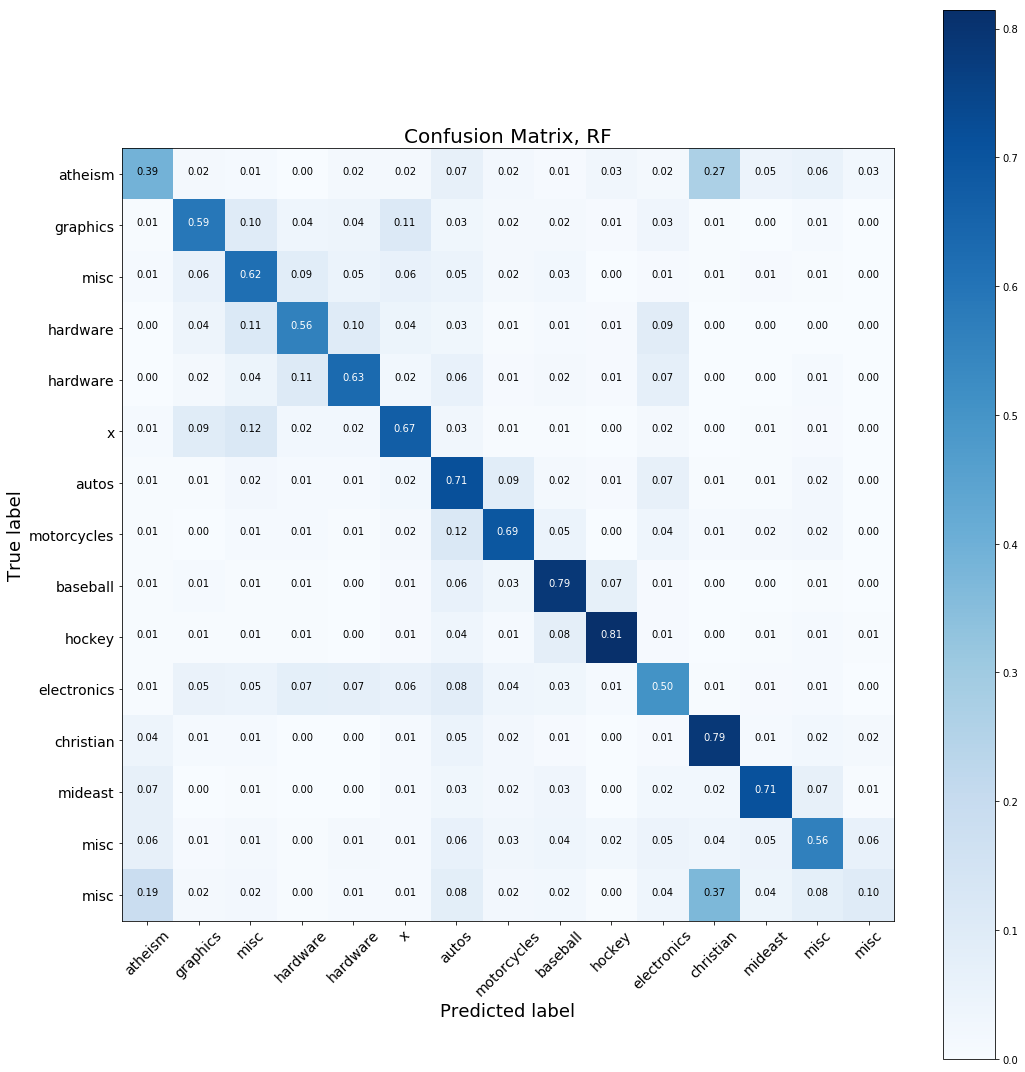

In [20]:
cmt_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cmt_rf, title='Confusion Matrix, RF')

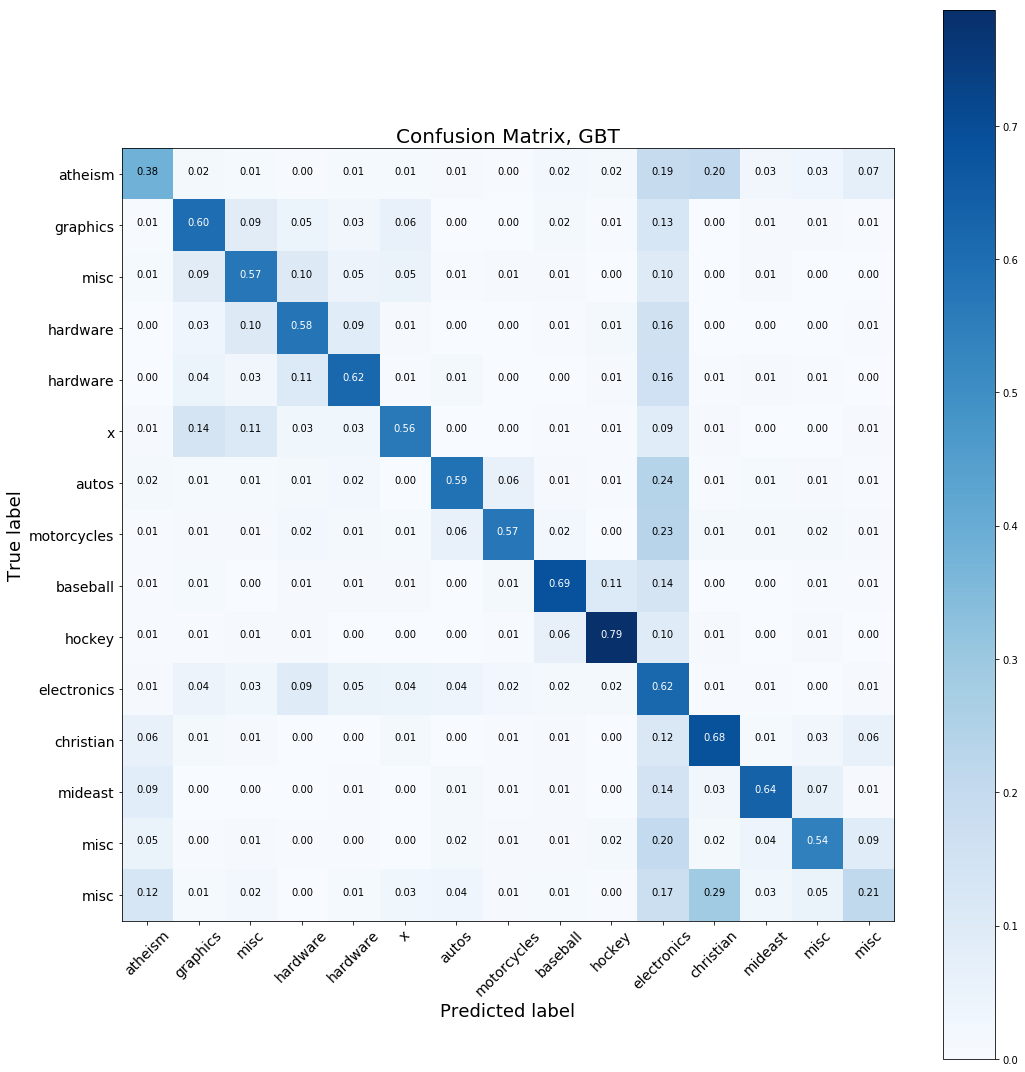

In [21]:
cmt_gbt = confusion_matrix(y_test, y_pred_gbt)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, GBT')

### Feature Importances:

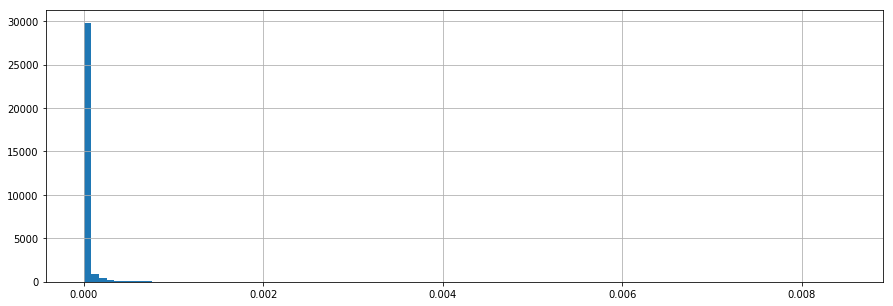

In [22]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)

(0, 0.001)

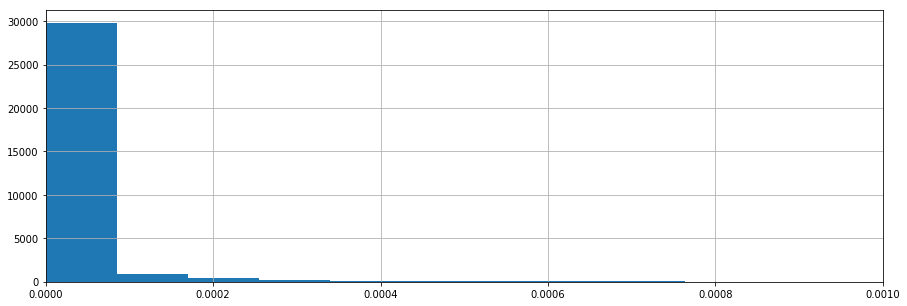

In [23]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)
plt.xlim(0, 0.001)

**Create feature selector:**

In [24]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=10)).fit(X_train, y_train)

In [25]:
X_train_transformed = feature_selector.transform(X_train)
X_test_transformed = feature_selector.transform(X_test)

print X_train_transformed.shape, X_test_transformed.shape

(8401, 4735) (5592, 4735)


**Train and evaluate the new classifier:**

In [26]:
predictor_lr_ = LogisticRegression().fit(X_train_transformed, y_train)

In [27]:
y_pred_lr_ = predictor_lr_.predict(X_test_transformed)
print 'LR (with feature selection) accuracy: {}%'.format(round(np.mean(y_test == y_pred_lr_), 2))

LR (with feature selection) accuracy: 0.64%


### Binary Classification

In [28]:
predictor_oneVSall = OneVsRestClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [29]:
y_pred_onevsall = predictor_oneVSall.predict(X_test)
print 'One-VS-all accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsall), 2))

One-VS-all accuracy: 0.66%


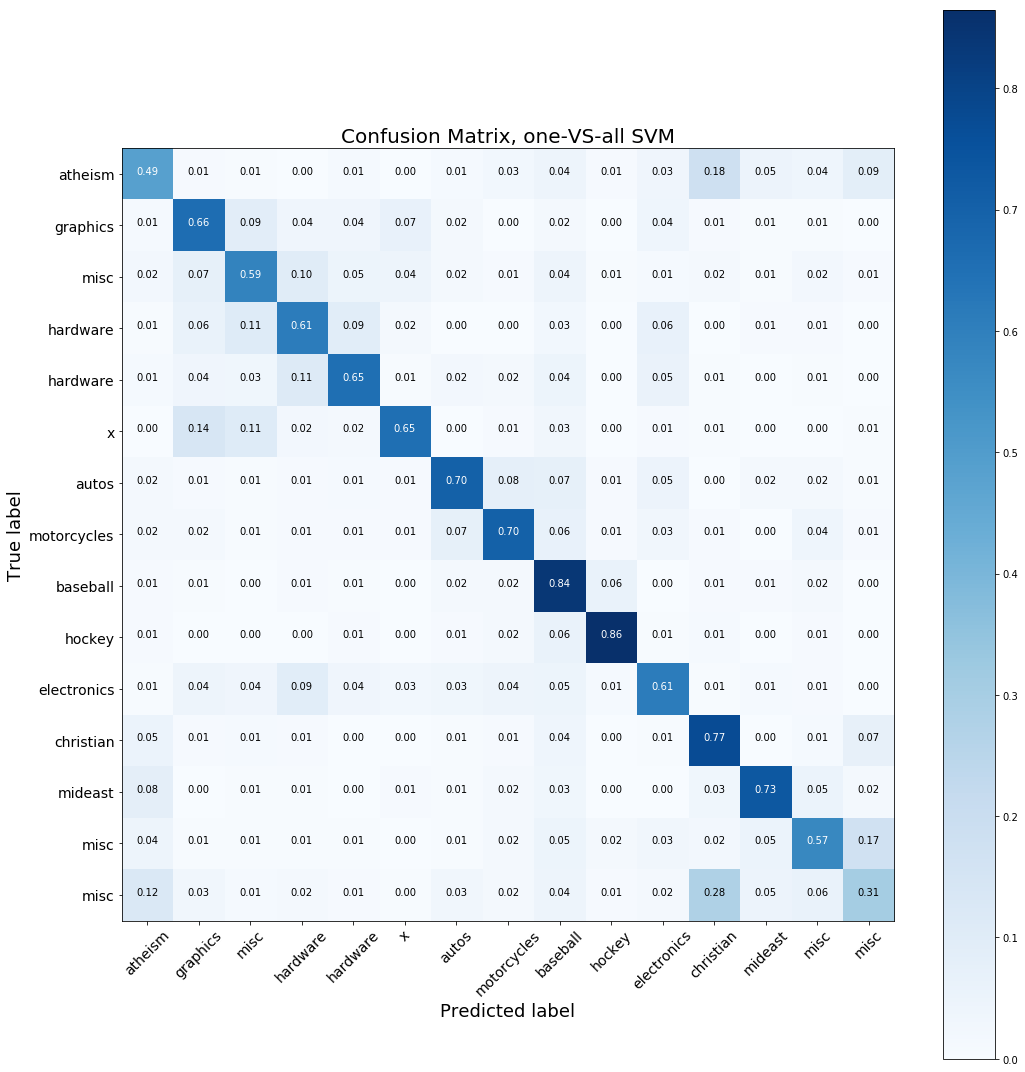

In [30]:
cmt_svm_onevsall = confusion_matrix(y_test, y_pred_onevsall)
plot_confusion_matrix(cmt_svm_onevsall, title='Confusion Matrix, one-VS-all SVM')

In [31]:
predictor_oneVSone = OneVsOneClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [32]:
y_pred_onevsone = predictor_oneVSone.predict(X_test)
print 'One-VS-one accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsone), 2))

One-VS-one accuracy: 0.66%


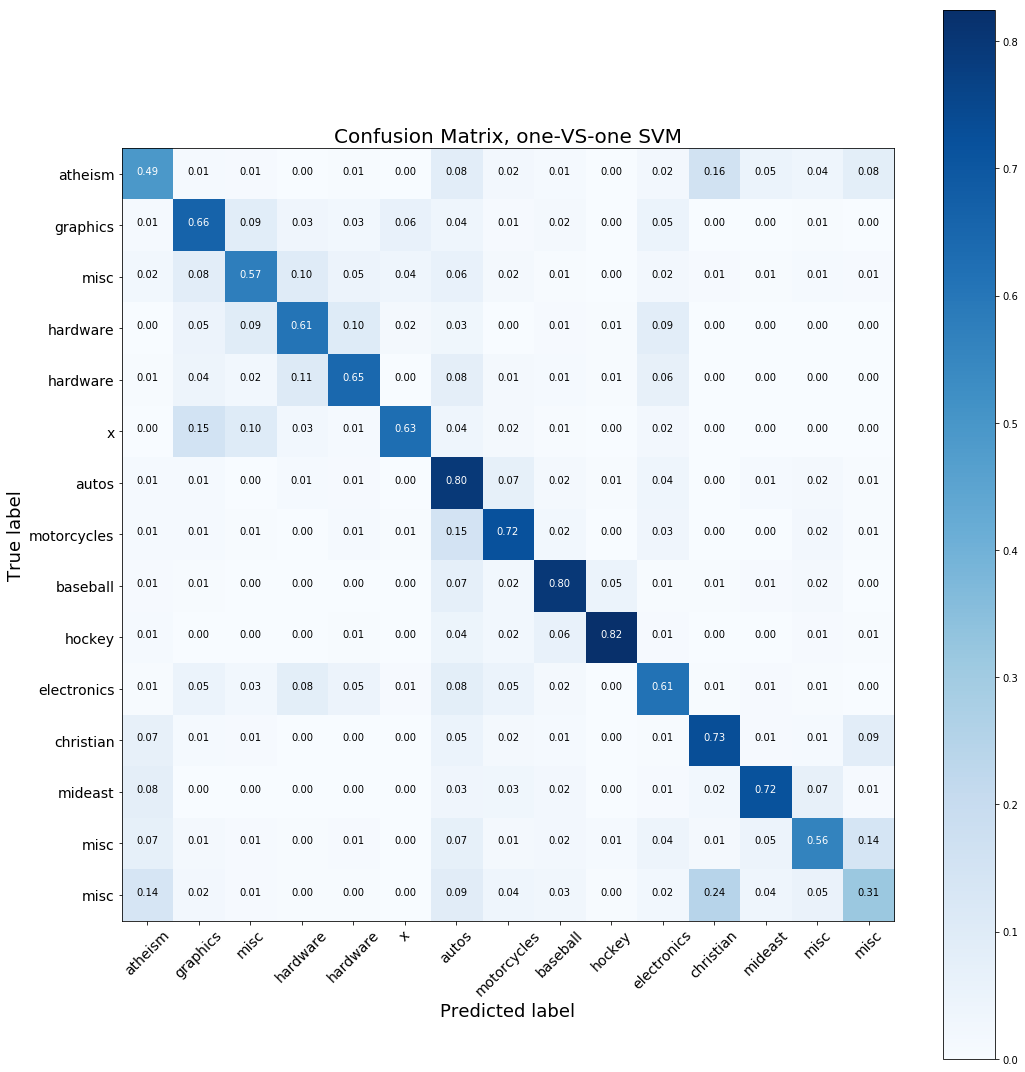

In [33]:
cmt_svm_onevsone = confusion_matrix(y_test, y_pred_onevsone)
plot_confusion_matrix(cmt_svm_onevsone, title='Confusion Matrix, one-VS-one SVM')

In [34]:
for c in np.unique(y_train):
    print 'Class \'{}\' samples N: {}'.format(c, y_train[y_train == c].shape[0])

Class '0' samples N: 480
Class '1' samples N: 584
Class '2' samples N: 591
Class '3' samples N: 590
Class '4' samples N: 578
Class '5' samples N: 593
Class '6' samples N: 594
Class '7' samples N: 598
Class '8' samples N: 597
Class '9' samples N: 600
Class '10' samples N: 591
Class '11' samples N: 599
Class '12' samples N: 564
Class '13' samples N: 465
Class '14' samples N: 377


In [36]:
X_train_bin = X_train[(y_train == 9) | (y_train == 14)]
y_train_bin = y_train[(y_train == 9) | (y_train == 14)]

y_train_bin[y_train_bin == 9] = 0
y_train_bin[y_train_bin == 14] = 1

print X_train_bin.shape, y_train_bin.shape

(977, 31911) (977,)


In [37]:
X_test_bin = X_test[(y_test == 9) | (y_test == 14)]
y_test_bin = y_test[(y_test == 9) | (y_test == 14)]

y_test_bin[y_test_bin == 9] = 0
y_test_bin[y_test_bin == 14] = 1

print X_test_bin.shape, y_test_bin.shape

(650, 31911) (650,)


In [38]:
one_binary_predictor = RandomForestClassifier(n_estimators=100).fit(X_train_bin, y_train_bin)

### [Metrics](https://en.wikipedia.org/wiki/Precision_and_recall)

In [39]:
y_pred_binary = one_binary_predictor.predict(X_test_bin)

print 'Binary classifiers accuracy: {}%'.format(round(np.mean(y_pred_binary == y_test_bin), 2))

Binary classifiers accuracy: 0.92%


In [40]:
def FP(y_true, y_pred):
    return float(np.sum(y_true[y_true == 0] != y_pred[y_true == 0]))

In [41]:
def TP(y_true, y_pred):
    return float(np.sum(y_true[y_true == 1] == y_pred[y_true == 1]))

In [42]:
def FN(y_true, y_pred):
    return float(np.sum(y_true[y_true == 1] != y_pred[y_true == 1]))

In [43]:
def TN(y_true, y_pred):
    return float(np.sum(y_true[y_true == 0] == y_pred[y_true == 0]))

In [44]:
fp = FP(y_test_bin, y_pred_binary)
fn = FN(y_test_bin, y_pred_binary)
tp = TP(y_test_bin, y_pred_binary)
tn = TN(y_test_bin, y_pred_binary)

print 'TP = {}, FP = {}, TN = {}, FN = {}\n---------------------------------------------\nsum = {}'.format(tp, fp, tn, fn, tp + fp + tn + fn)

TP = 219.0, FP = 21.0, TN = 378.0, FN = 32.0
---------------------------------------------
sum = 650.0


In [46]:
P = precision_score(y_test_bin, y_pred_binary)
R = recall_score(y_test_bin, y_pred_binary)

print 'Precision: {}, Recall: {}'.format(P, R)

Precision: 0.9125, Recall: 0.872509960159


In [47]:
print tp / (tp + fp), tp / (tp + fn)

0.9125 0.872509960159


In [48]:
print 'F1: {}'.format(f1_score(y_test_bin, y_pred_binary))

F1: 0.892057026477


In [49]:
print 2.0 * P * R / (P + R)

0.8920570264765784


In [50]:
scores_binary = one_binary_predictor.predict_proba(X_test_bin)[:, 1]

print scores_binary.shape

(650,)


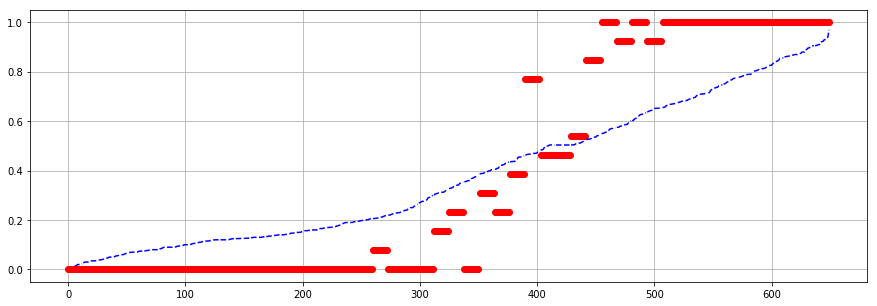

In [51]:
plt.figure(figsize=(15, 5))

N_batch = 50
inds = np.argsort(scores_binary)
scores_sorted = scores_binary[inds]
y_sorted = y_test_bin[inds]
q = len(y_test_bin) // N_batch

for i in range(N_batch):
    plt.plot(range(q * i, q * (i + 1)), scores_sorted[q * i : q * (i + 1)], '--b')
    plt.plot(range(q * i, q * (i + 1)), [np.mean(y_sorted[q * i : q * (i + 1)])] * q, 'ro')
    
plt.grid(True)

In [52]:
fpr, tpr, thresholds = roc_curve(y_test_bin, scores_binary)

(-0.1, 1.1)

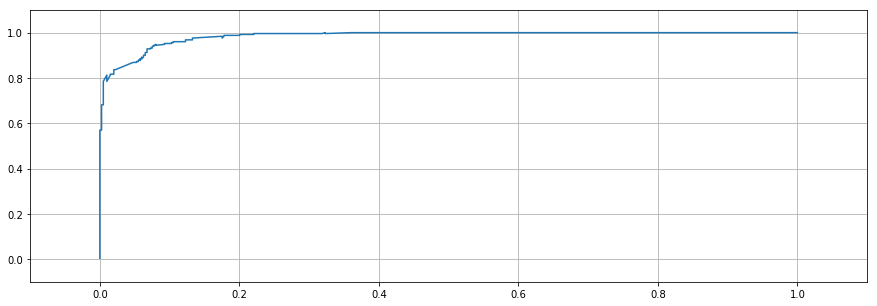

In [53]:
plt.figure(figsize=(15, 5))

inds = np.argsort(fpr)
plt.plot(fpr[inds], tpr[inds])
plt.grid(True)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

In [54]:
roc_auc = roc_auc_score(y_test_bin, scores_binary)

print 'AUC score: {}'.format(roc_auc, 2)

AUC score: 0.983794146721


In [56]:
f1_max = 0
y_pred_best = None

for thr in thresholds:
    y_pred_tuned = scores_binary.copy()
    y_pred_tuned[y_pred_tuned < thr] = 0
    y_pred_tuned[y_pred_tuned >= thr] = 1
    
    f1 = f1_score(y_test_bin, y_pred_tuned)
    if f1 > f1_max:
        f1_max = f1
        y_pred_best = y_pred_tuned
    if f1 > 0.894308943089:
        print 'thr = {}: F1 +{}'.format(thr, round(f1 - 0.8920570264765784, 4))
        
print
print 'Max. F1: {}'.format(round(f1_max, 3))

thr = 0.504785655909: F1 +0.0035
thr = 0.485095370974: F1 +0.0031
thr = 0.480729676346: F1 +0.0057
thr = 0.480516493463: F1 +0.0039
thr = 0.469977336138: F1 +0.0083
thr = 0.46990937657: F1 +0.0066
thr = 0.467158472881: F1 +0.0131
thr = 0.466458427364: F1 +0.0113
thr = 0.462352420533: F1 +0.0199
thr = 0.458340955617: F1 +0.0163
thr = 0.45658557643: F1 +0.0184
thr = 0.455257528258: F1 +0.0167
thr = 0.454569310697: F1 +0.0209
thr = 0.447121968459: F1 +0.0191
thr = 0.44270785316: F1 +0.0212
thr = 0.437210235221: F1 +0.0195
thr = 0.437015086662: F1 +0.0216
thr = 0.434122501169: F1 +0.0129
thr = 0.430693801046: F1 +0.015
thr = 0.421791120273: F1 +0.0081
thr = 0.420593583687: F1 +0.0102
thr = 0.419017649164: F1 +0.0085
thr = 0.409890690352: F1 +0.0106
thr = 0.396582332444: F1 +0.003

Max. F1: 0.914


In [57]:
print np.mean(y_test_bin == y_pred_best)

0.9307692307692308


## Ensembling

In [58]:
print np.mean(RandomForestClassifier(n_estimators=10).fit(X_train, y_train).predict(X_test) == y_test)
print np.mean(RandomForestClassifier(n_estimators=100, criterion='entropy').fit(X_train, y_train).predict(X_test) == y_test)
print np.mean(GradientBoostingClassifier(n_estimators=10).fit(X_train, y_train).predict(X_test) == y_test)

0.503755364806867
0.574928469241774
0.5160944206008584


In [59]:
ensemble_soft = VotingClassifier([('rf_gini_10', RandomForestClassifier(n_estimators=10)),
                                  ('rf_entropy_100', RandomForestClassifier(n_estimators=100, criterion='entropy')),
                                  ('gbt_100', GradientBoostingClassifier(n_estimators=10))], voting='soft', n_jobs=1)

ensemble_hard = VotingClassifier([('rf_gini_10', RandomForestClassifier(n_estimators=10)),
                                  ('rf_entropy_100', RandomForestClassifier(n_estimators=100, criterion='entropy')),
                                  ('gbt_100', GradientBoostingClassifier(n_estimators=10))], voting='hard', n_jobs=1)

In [60]:
ensemble_soft.fit(X_train, y_train)
ensemble_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('rf_gini_10', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
          ...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [61]:
y_pred_hard = ensemble_hard.predict(X_test)
y_pred_soft = ensemble_soft.predict(X_test)

print y_pred_hard.shape, y_pred_soft.shape

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(5592,) (5592,)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [62]:
print 'Hard voting accuracy: {}%'.format(round(np.mean(y_test == y_pred_hard), 2))
print 'Soft voting accuracy: {}%'.format(round(np.mean(y_test == y_pred_soft), 2))

Hard voting accuracy: 0.57%
Soft voting accuracy: 0.58%
